# IMDb Review Classification using Transformers

**Author:** Sarang Galada<br>
**Email ID:** sarang.galada@gmail.com<br>
**Date created:** 07/11/2023<br><br>
**Description:** Classification of IMDb movie reviews as `positive` or `negative` using Transformers and `keras_nlp`

*   *Problem*: Binary text classification
*   *Dataset*: IMDb movie reviews
*   *Model*: Transformer based
*   *Key library used*: `keras_nlp`





**Scheme**


1.   Load required libraries
2.   Load raw data
3.   Prepare text data
4.   Vectorize text data into embeddings
5.   Construct Transformer model
6.   Train model
7.   Evaluate model

## Loading the libraries

Before we start with the implementation, let's import all the necessary packages.

In [ ]:
!pip install keras-nlp -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.9 MB/s eta 0:00:00


In [ ]:
# Importing required libraries

import numpy as np
import matplotlib.pyplot as plt
import string
import re

import tensorflow as tf
from tensorflow import keras
import keras_nlp

keras.utils.set_random_seed(42)

Using TensorFlow backend


Let's also define our hyperparameters upfront.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 3
MAX_SEQUENCE_LENGTH = 512
VOCAB_SIZE = 15000

EMBED_DIM = 128
INTERMEDIATE_DIM = 512
NUM_HEADS = 2


In [ ]:
# BATCH_SIZE = 32
# EPOCHS = 5
# MAX_SEQUENCE_LENGTH = 150   # Only consider the first 150 words of each movie review
# VOCAB_SIZE = 20000  # Only consider the top 20k frequently ocurring words of the vocabulary

# EMBED_DIM = 256
# INTERMEDIATE_DIM = 512
# NUM_HEADS = 8

## Loading the raw data

Download and extract the IMDB dataset

In [ ]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)
# print(x_train.size)  # No. of training text sequences
# print(x_test.size)   # No. of testing text sequences

In [ ]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3241k      0  0:00:25  0:00:25 --:--:-- 1954k


In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2023-11-12 08:27:55--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  10.9MB/s    in 10s     

2023-11-12 08:28:06 (7.65 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Let us inspect the raw data files

In [ ]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


The directory contains two sub-directories: `train` and `test`. Each subdirectory
in turn contains two folders: `pos` and `neg` for positive and negative reviews,
respectively.

In [ ]:
!ls aclImdb/train

labeledBow.feat  neg  pos  unsup  unsupBow.feat  urls_neg.txt  urls_pos.txt  urls_unsup.txt


In [ ]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


This is a supervised learning project, hence let's delete the `./aclImdb/train/unsup`
folder since it has unlabelled samples.

In [ ]:
!rm -r aclImdb/train/unsup

Use the `keras.utils.text_dataset_from_directory` utility to generate
our labelled `tf.data.Dataset` dataset from text files.

## Preparing the data

The data in its current form is raw and needs to be preprocessed

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=BATCH_SIZE
)

print(f"\nNumber of batches (batch_size={BATCH_SIZE}) in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches (batch_size={BATCH_SIZE}) in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches (batch_size={BATCH_SIZE}) in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Number of batches (batch_size=64) in raw_train_ds: 313
Number of batches (batch_size=64) in raw_val_ds: 79
Number of batches (batch_size=64) in raw_test_ds: 391


A peep into the IMDb reviews training set

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print((text_batch.numpy()[i]))
        print(label_batch.numpy()[i])

b'An illegal immigrant resists the social support system causing dire consequences for many. Well filmed and acted even though the story is a bit forced, yet the slow pacing really sets off the conclusion. The feeling of being lost in the big city is effectively conveyed. The little person lost in the big society is something to which we can all relate, but I cannot endorse going out of your way to see this movie.'
0
b"To get in touch with the beauty of this film pay close attention to the sound track, not only the music, but the way all sounds help to weave the imagery. How beautifully the opening scene leading to the expulsion of Gino establishes the theme of moral ambiguity! Note the way music introduces the characters as we are led inside Giovanna's marriage. Don't expect to find much here of the political life of Italy in 1943. That's not what this is about. On the other hand, if you are susceptible to the music of images and sounds, you will be led into a word that reaches beyond

We will now preprocess the text:<br>

1.   Convert text to lowercase
2.   Remove HTML tags
3.   Remove punctuations

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
train_ds = raw_train_ds.map(lambda x, y: (custom_standardization(x), y))
val_ds = raw_val_ds.map(lambda x, y: (custom_standardization(x), y))
test_ds = raw_test_ds.map(lambda x, y: (custom_standardization(x), y))


Let's print a few samples after preprocessing.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print((text_batch.numpy()[i]))
        print(label_batch.numpy()[i])

b'nobody said movies had to be realistic did they i really liked this movie because i remember when i first saw it in junior high for all the kids who remember the pmrc and albums before there were warning stickers its a cool story for all those kids who were part of the mid to late 80s headbanger crowd'
1
b'a different look at horror the styling differences between american and russian films is interesting however from my american perspective this movie just wasnt that good the protagonist marie played by anastasia hille wasnt a pleasant character and i had a hard time identifying with her she was disagreeable most of the time and confused for much of what little time was left also too much time was spent in bringing her to the main location of the film then a long time passed before any real suspense built up once that happened it seemed volume was used as the main effect which was more annoying than anything else the concept was more original than most directtovideo movies and they 

In [ ]:
# train_ds = train_ds.map(lambda x, y: (tf.strings.lower(x), y))
# val_ds = val_ds.map(lambda x, y: (tf.strings.lower(x), y))
# test_ds = test_ds.map(lambda x, y: (tf.strings.lower(x), y))

In [ ]:
# for text_batch, label_batch in train_ds.take(1):
#     for i in range(3):
#         print(text_batch.numpy()[i])
#         print(label_batch.numpy()[i])


b'an illegal immigrant resists the social support system causing dire consequences for many. well filmed and acted even though the story is a bit forced, yet the slow pacing really sets off the conclusion. the feeling of being lost in the big city is effectively conveyed. the little person lost in the big society is something to which we can all relate, but i cannot endorse going out of your way to see this movie.'
0
b"to get in touch with the beauty of this film pay close attention to the sound track, not only the music, but the way all sounds help to weave the imagery. how beautifully the opening scene leading to the expulsion of gino establishes the theme of moral ambiguity! note the way music introduces the characters as we are led inside giovanna's marriage. don't expect to find much here of the political life of italy in 1943. that's not what this is about. on the other hand, if you are susceptible to the music of images and sounds, you will be led into a word that reaches beyond

## Tokenizing the data

In order to tokenize our dataset, we must first train the `keras_nlp` tokenizer on the text corpus in order to get a vocabulary of subwords.

The trained tokenizer can then be applied to the subwords in the vocabulary to encode them into tokens

In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

train_sentences = [element[0] for element in train_ds]
vocab = train_word_piece(train_ds, VOCAB_SIZE, reserved_tokens)

Let's see some tokens!

In [ ]:
print("Tokens: ", vocab[100:110])

Tokens:  ['à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é']


Now, let's define the tokenizer. We will configure the tokenizer with the
the vocabularies trained above. We will define a maximum sequence length so that
all sequences are padded to the same length, if the length of the sequence is
less than the specified sequence length. Otherwise, the sequence is truncated.

In [ ]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=False,
    sequence_length=MAX_SEQUENCE_LENGTH,
)

Let's try and tokenize a sample from our dataset! To verify whether the text has
been tokenized correctly, we can also detokenize the list of tokens back to the
original text.

In [ ]:
input_sentence_ex = train_ds.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))


Sentence:  tf.Tensor(b'this picture seemed way to slanted, it\'s almost as bad as the drum beating of the right wing kooks who say everything is rosy in iraq. it paints a picture so unredeemable that i can\'t help but wonder about it\'s legitimacy and bias. also it seemed to meander from being about the murderous carnage of our troops to the lack of health care in the states for ptsd. to me the subject matter seemed confused, it only cared about portraying the military in a bad light, as a) an organzation that uses mind control to turn ordinary peace loving civilians into baby killers and b) an organization that once having used and spent the bodies of it\'s soldiers then discards them to the despotic bureacracy of the v.a. this is a legitimate argument, but felt off topic for me, almost like a movie in and of itself. i felt that "the war tapes" and "blood of my brother" were much more fair and let the viewer draw some conclusions of their own rather than be beaten over the head with t

## Formatting the dataset

Next, we'll format our datasets in the form that will be fed to the models.

In [ ]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(512).prefetch(16).cache()

train_ds = make_dataset(train_ds)
val_ds = make_dataset(val_ds)
test_ds = make_dataset(test_ds)

Splitting `test_ds` into `x_test` and `y_test` for evaluation purposes later

In [ ]:
x_test = test_ds.map(lambda x, y: x)
print(x_test.cardinality())
y_test = test_ds.map(lambda x, y: y)
print(y_test.cardinality())

tf.Tensor(391, shape=(), dtype=int64)
tf.Tensor(391, shape=(), dtype=int64)


In [ ]:
# Converting into Numpy array for convenience

y_test_np = []
for batch in y_test.take(391):
  for i in batch:
    y_test_np.append(i.numpy())

y_test=np.reshape(np.array(y_test_np), (-1,1))

## Constructing the Transformer model

Model description: `Input` -> `TokenAndPositionEmbedding` -> `3 layer Transformer encoder stack` -> `GlobalAvgPooling1D` -> `20% Dropout` -> `30 unit ReLU activated Dense layer` -> `20 unit ReLU activated Dense layer` -> `2 unit Softmax activated Output`

In [ ]:
input_ = keras.Input(shape=(None,), dtype="int64", name="input_")


x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer_classifier = keras.Model(input_ids, outputs, name="transformer_classifier")

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 128)         1985536   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, None, 128)         198272    
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, None, 128)         198272    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, None, 12

In [ ]:
transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ (InputLayer)         [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         5158400   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, None, 256)         527104    
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, None, 256)         527104    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, None, 256)         527104

## Training the Model

Now that both the data and model are ready, we can fit the model to the data

In [ ]:
# Fit the model, specifying number of epochs
transformer_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

## Evaluating the Model

The model's performance on the test set

Calculating the model's loss value and accuracy on the test set

In [ ]:
test_loss, test_accuracy = transformer_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)
print("Test-loss: %f, Test-accuracy: %f" % (test_loss, test_accuracy))

391/391 [==============================] - 28s 62ms/step - loss: 0.4890 - accuracy: 0.8432
Test-loss: 0.489041, Test-accuracy: 0.843200


In [ ]:
y_probs = transformer_classifier.predict(x_test)
y_predict = np.array((np.rint(y_probs)).astype(int))

391/391 [==============================] - 24s 59ms/step


Let us take a peek into the predictions and see how they compare with the ground truth

In [ ]:
for i in range(15):
  print(f"True: {y_test[i]}, Predicted: {y_predict[i]}")

True: [0], Predicted: [0]
True: [0], Predicted: [0]
True: [0], Predicted: [1]
True: [1], Predicted: [1]
True: [1], Predicted: [1]
True: [0], Predicted: [0]
True: [0], Predicted: [0]
True: [0], Predicted: [0]
True: [0], Predicted: [1]
True: [0], Predicted: [1]
True: [0], Predicted: [0]
True: [1], Predicted: [0]
True: [1], Predicted: [1]
True: [1], Predicted: [1]
True: [1], Predicted: [1]


Let us view the Classification report and Confusion matrix of the model's predictions

Classification report for classifier <keras.src.engine.functional.Functional object at 0x7c562b4f6950>:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     12500
           1       0.90      0.78      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000




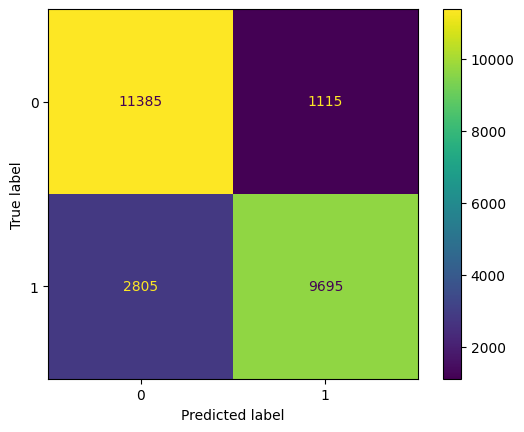

In [ ]:
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
% (transformer_classifier, metrics.classification_report(y_true = y_test, y_pred = y_predict)))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confMatrix = confusion_matrix(y_true = y_test, y_pred = y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix = confMatrix)

disp.plot()
plt.show()

This Transformer model gives a `weighted-avg f1-score` of 0.84!